In [145]:
import control as ctl
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
from scipy.optimize import fsolve
from tbcontrol.symbolic import routh
import pandas as pd

# IMPORTANDO DADOS

In [146]:
path = 'DataBase.csv'
df   = pd.read_csv(path)
df.head()

,time,pressure
0,0.000,34.1818
1,0.000,34.2099
2,0.096,34.2129
3,0.195,34.1739
4,0.293,34.1464


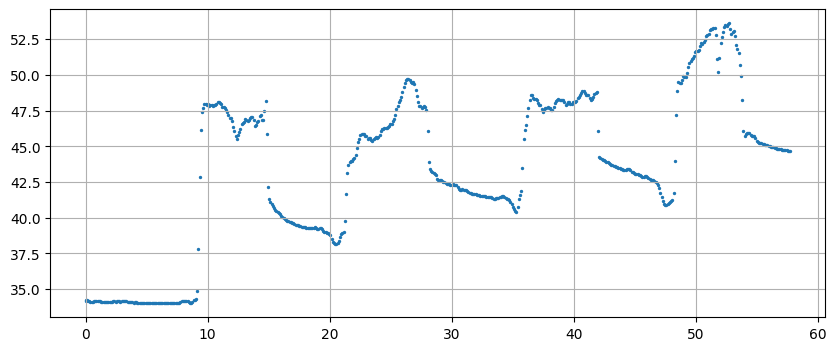

In [147]:
plt.figure(figsize=(10, 4))
plt.scatter(df.time, df.pressure, s=2)
plt.grid()

# NORMALIZANDO DADOS

In [148]:
T = 0.100

In [149]:
def normalizeData(df, timeKey, responseKey, T=0.15):
    initTime  = df[timeKey].iloc[0]
    finalTime = df[timeKey].iloc[-1] + T
    timeData  = np.arange(initTime, finalTime, T)
    
    lastValue = df[responseKey].iloc[0]
    desired = []

    for t in timeData:
        filtered = df.loc[df[timeKey] <= t][responseKey]
        
        if not filtered.empty:
            lastValue = filtered.iloc[-1]
        
        desired.append(lastValue)
    
    return timeData, desired


def normalizeTable(df, key, T=0.15):
    table = {key: []}

    for column in df.columns:
        if column == key:
            continue

        xData, yData = normalizeData(df, key, column, T)
        table[column] = yData

    table[key] = xData
    return pd.DataFrame(table) 


df['time'] = df.time - df.time[0]
df = normalizeTable(df, 'time', T)
df

,time,pressure
0,0.0,34.2099
1,0.1,34.2129
2,0.2,34.1739
3,0.3,34.1464
4,0.4,34.1162
...,...,...
574,57.4,44.7218
575,57.5,44.7158
576,57.6,44.6948
577,57.7,44.6635


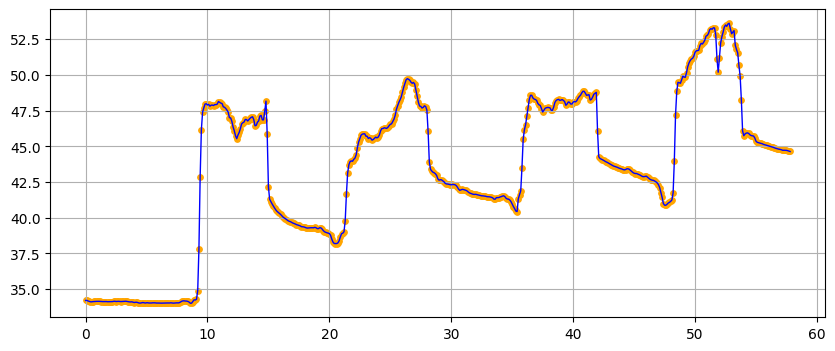

In [150]:
xData, yData = df.time.values, df.pressure.values

plt.figure(figsize=(10, 4))
plt.scatter(xData, yData, s=15, color='orange')
plt.plot(xData, yData, linewidth=1, color='blue')
plt.grid()

# FILTRO DE FREQUÊNCIA
- A função de transferência do filtro de primeira ordem tem cara: 

- $C(s) = \frac{1}{Ks + 1}$, $\,\,\,\,\,\,\,\,$ onde $K = \frac{1}{w_c}$

In [151]:
Ts = 3.0
s  = ctl.TransferFunction.s
C  = 1/(0.25*Ts*s + 1)
C

TransferFunction(array([1]), array([0.75, 1.  ]))

**COMPARAÇÃO COM O FILTRO PADRÃO** $\Rightarrow$ Vamos comparar o filtro perfeito, construído em numpy, com o filtro feito pela função de transferência, os dois devem ser aproximadamente iguais

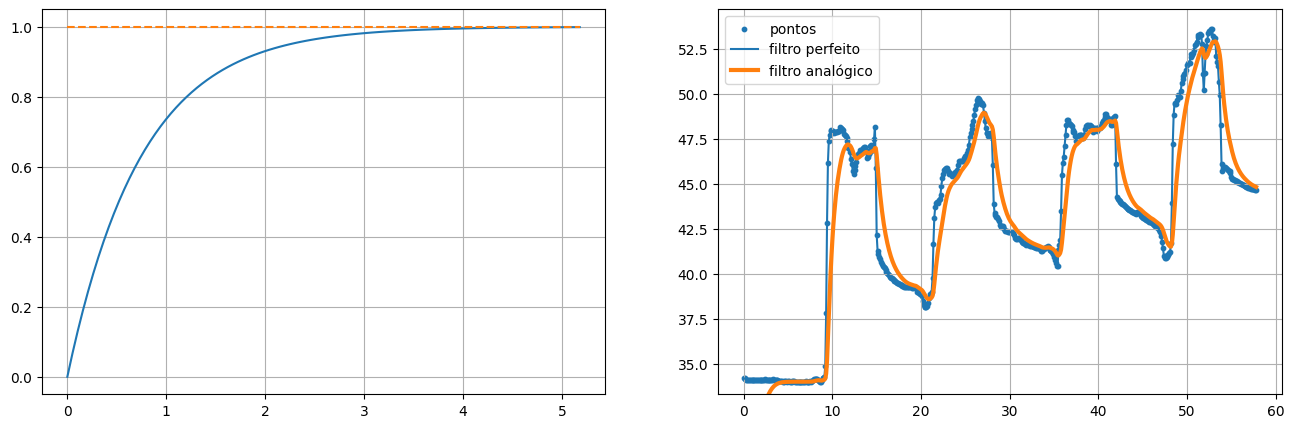

In [152]:
time, response = ctl.step_response(C)
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(time, response)
plt.plot(time, [1 for i in time], '--')
plt.grid()

xTest, yTest  = df.time.values, df.pressure.values
timeArray     = np.linspace(xTest[0], xTest[-1], len(xTest))
time, reponse = ctl.forced_response(C, T=timeArray, U=yTest)

plt.subplot(1, 2, 2)
plt.scatter(df.time, df.pressure, s=10, label='pontos')
plt.plot(xData, yData, label='filtro perfeito')
plt.plot(time, reponse, label='filtro analógico', linewidth=3)

plt.ylim(min(yData)*0.98, max(yData)*1.02)
plt.legend()
plt.grid()

# FILTRO DIGITAL

In [153]:
C

TransferFunction(array([1]), array([0.75, 1.  ]))

In [154]:
s = ctl.TransferFunction.s
C_z = ctl.c2d(C, T, method='zoh')
C_z

TransferFunction(array([0.12482668]), array([ 1.        , -0.87517332]), 0.1)

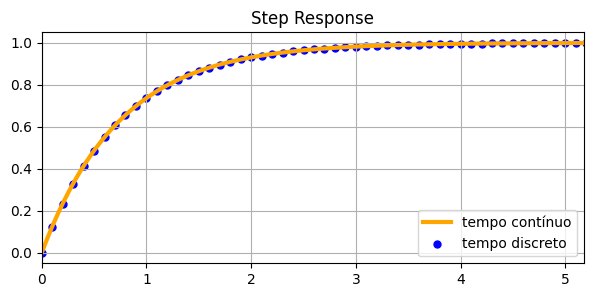

In [155]:
plt.figure(figsize=(7, 3))
time, response = ctl.step_response(C)

plt.plot(time, response, color='orange', linewidth=3, label='tempo contínuo')
plt.xlim(min(time), max(time))

time, response = ctl.step_response(C_z)
plt.scatter(time, response, color='blue', s=25, label='tempo discreto')

plt.title('Step Response')
plt.legend()
plt.grid()

- As funções abaixo serão usadas para discretizar a função de transferência no domínio $z$ para uma função a partir dos seus estados anteriores

In [156]:
def getDigitalFraction(C_z):
    num, den = ctl.tfdata(C_z)
    num = np.squeeze(num)
    den = np.squeeze(den)

    num = num/den[0]
    den = den/den[0]

    if type(num) == np.float64:
        num = np.array([num])

    return list(num), list(den)


num, den = getDigitalFraction(C_z)
num, den

([0.12482668095705252], [1.0, -0.8751733190429475])

In [157]:
def getDigitalFunction(C_z):
    num, den = getDigitalFraction(C_z)
    out = ''
    
    for i in range(0, len(num)): 
        out += f'X_n{i}*({num[i]:.6f}) + '

    for i in range(1, len(den)): 
        out += f'Y_n{i}*({-1*den[i]:.6f}) + '
    
    return out.replace('X_n0', 'X_n')[:-3]


out = getDigitalFunction(C_z)
print(out + ';')

X_n*(0.124827) + Y_n1*(0.875173);


- Criando a função no "estilo" C++ para confirmar se a máquina consegue implementar

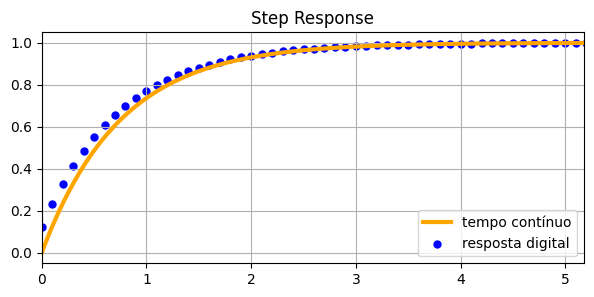

In [158]:
Y_n1 = X_n1 = 0

def compute(X_n):
    global Y_n1, X_n1
    Y_n = eval(out)
    X_n1 = X_n
    Y_n1 = Y_n
    return Y_n


plt.figure(figsize=(7, 3))
time, response = ctl.step_response(C)
plt.plot(time, response, color='orange', linewidth=3, label='tempo contínuo')
plt.xlim(min(time), max(time))

time     = np.arange(0, 20, T)
response = [compute(1) for i in time] 
plt.scatter(time, response, color='blue', s=25, label='resposta digital')

plt.title('Step Response')
plt.grid()
plt.legend()
plt.show()

- Comparando o filtro digital com o filtro perfeito

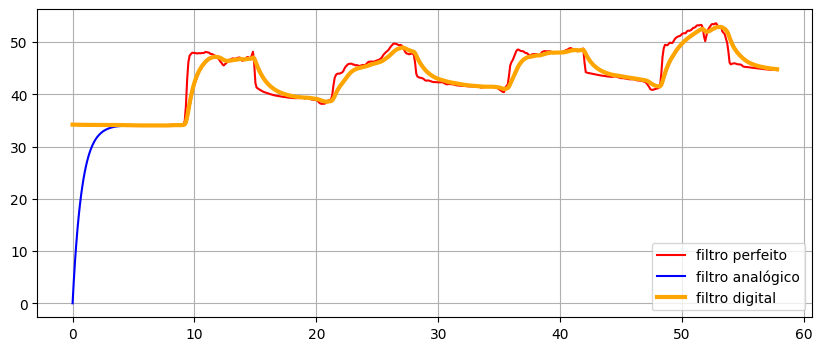

In [159]:
xTest, yTest  = df.time.values, df.pressure.values
timeArray     = np.linspace(xTest[0], xTest[-1], len(xTest))
time, reponse = ctl.forced_response(C, T=timeArray, U=yTest)
for i in range(100): compute(yTest[0]) # RECALIBRANDO

plt.figure(figsize=(10, 4))
plt.plot(xData, yData, label='filtro perfeito', color='red')
plt.plot(time, reponse, label='filtro analógico', color='blue')
plt.plot(xTest, [compute(y) for y in yTest], label='filtro digital', color='orange', linewidth=3)
plt.legend()
plt.grid()

# COMPARAÇÃO GERAL DOS DADOS

,time,pressure
0,0.0,34.2099
1,0.1,34.2129
2,0.2,34.1739
3,0.3,34.1464
4,0.4,34.1162


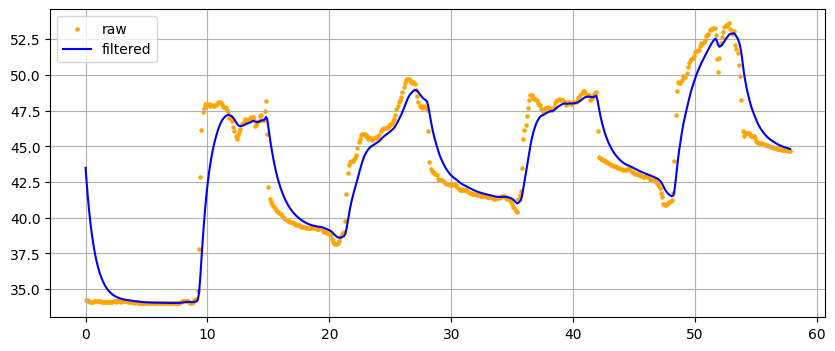

In [160]:
df = pd.read_csv(path) 

df['time'] = df.time - df.time[0]
df = normalizeTable(df, 'time', T)
display(df.head())

plt.figure(figsize=(10, 4))
plt.scatter(df.time, df.pressure, color='orange', s=5, label='raw')
plt.plot(df.time, [compute(y) for y in df.pressure], color='blue', label='filtered')

plt.grid()
plt.legend()